## Import & Data Load

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import seaborn as sns

train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

## Data Pre-processing

In [91]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]


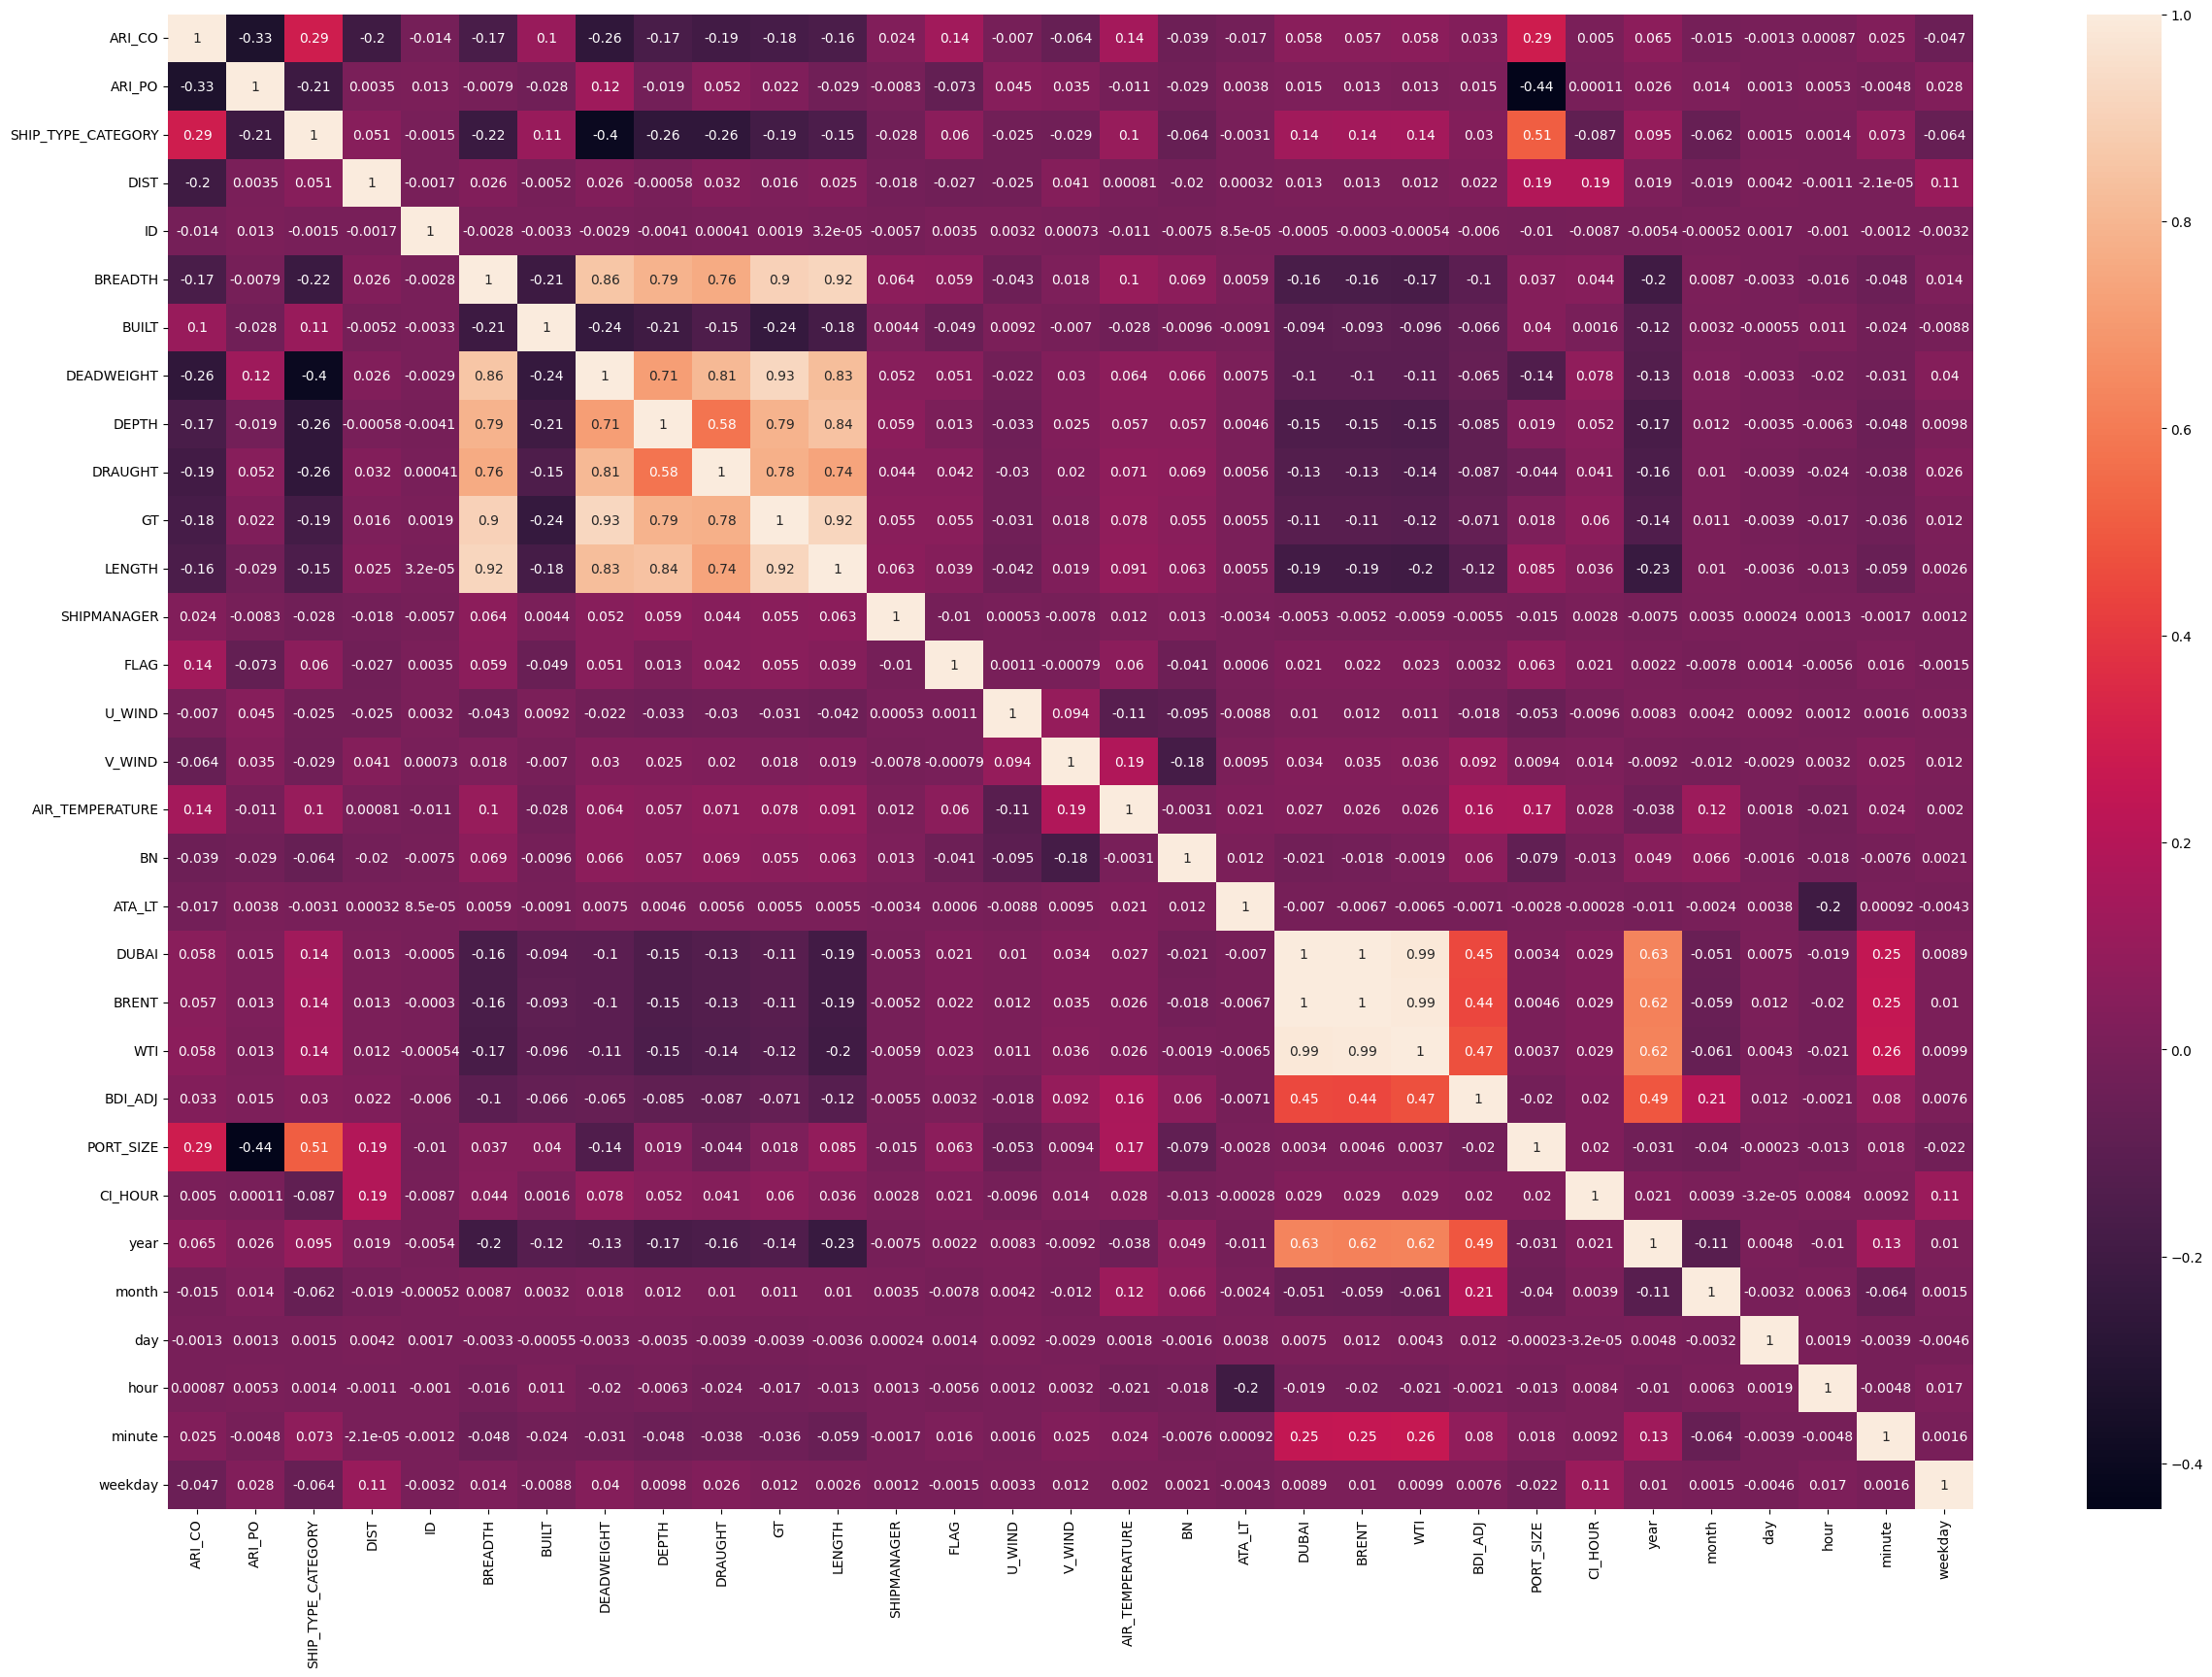

In [51]:
# heatmap
plt.figure(figsize = (30, 20))
sns.heatmap(train.corr() , annot =True)
plt.show()

## 모델 학습 및 특성 중요도 확인

In [92]:
X_train_reduced = train.drop(columns=['SHIP_TYPE_CATEGORY', 'ID', 
                                          'BREADTH', 'BUILT', 'DEPTH', 'DRAUGHT',
                                          'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND',
                                          'V_WIND', 'AIR_TEMPERATURE',
                                          'BN', 'ATA_LT', 'BRENT', 'WTI', 'hour', 
                                          'minute', 'weekday'])
X_test_reduced = test.drop(columns=['SHIP_TYPE_CATEGORY', 'ID', 
                                          'BREADTH', 'BUILT', 'DEPTH', 'DRAUGHT',
                                          'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND',
                                          'V_WIND', 'AIR_TEMPERATURE',
                                          'BN', 'ATA_LT', 'BRENT', 'WTI', 'hour', 
                                          'minute', 'weekday'])
y_train = train['CI_HOUR']

In [93]:
X_train_reduced.columns

Index(['ARI_CO', 'ARI_PO', 'DIST', 'DEADWEIGHT', 'GT', 'DUBAI', 'BDI_ADJ',
       'PORT_SIZE', 'CI_HOUR', 'year', 'month', 'day'],
      dtype='object')

In [61]:
# 2 sigma 이상치 제거 함수 정의
def remove_outliers_sigma(df, column_name):
  # 평균값 +- 표준편자 * 2
  lower = df[column_name].mean() - (df[column_name].std() *2)
  upper = df[column_name].mean() + (df[column_name].std() *2)

  # min ~ max 안에 포함되는 데이터만 저장
  removed_outliers = df[column_name].between(lower, upper)

  # 기존 데이터 사이즈와 이상치 제거 후 데이터 사이즈 비교
  bf  = df[column_name].size
  print(str(df[column_name][removed_outliers].size) + "/" + str(bf) + " data points remain.")

  # 전체 데이터에서 이상치에 해당하는 값만 임시저장
  index_names = df[~removed_outliers].index

  # 이상치 인덱스를 제거한 데이터프레임 반환
  return df.drop(index_names)

In [62]:
# 2 sigma 이상치 제거 함수 호출
X_train_reduced = remove_outliers_sigma(X_train_reduced, 'DIST')

343629/367441 data points remain.


In [63]:
X_train_reduced.head()

,ARI_CO,ARI_PO,DIST,DEADWEIGHT,GT,DUBAI,BDI_ADJ,PORT_SIZE,CI_HOUR,year,month,day
0,4,13,30.736578,73100,38600,42.01,1407.668330,0.001660,3.048333,2020,10,15
1,4,14,63.220425,37900,28100,67.53,2089.046774,0.001614,17.138611,2019,9,17
3,8,75,0.000000,1490,700,43.02,1169.853455,0.000069,0.000000,2020,9,18
4,16,46,8.813725,27600,19300,90.45,1107.944894,0.000197,96.030556,2022,8,13
6,8,101,0.000000,7930,6150,55.41,1577.304531,0.000356,0.000000,2021,1,25


In [64]:
feature_num = ['ARI_CO', 'ARI_PO', 'DIST', 'DEADWEIGHT', 'GT', 'DUBAI', 'BDI_ADJ',
            'PORT_SIZE']

feature  = ['year', 'month', 'day']


In [77]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train_reduced[feature_num]) # 스케일러에게 표준화해야하는 데이터가 무엇인지 알려줌 // 아하 누가 대상인지만 알려줌

X_num = scaler.transform(X_train_reduced[feature_num]) # 정규분포로 변환한 데이터를 반환해서 새 변수에 저장

# X_num은 리스트이므로 데이터프레임 형태로 변환
X_num = pd.DataFrame(data = X_num, index = X_train_reduced[feature_num].index, 
                                    columns = X_train_reduced[feature_num].columns)

# Research 다시 합치기
X = pd.concat([X_num, X_train_reduced[feature]], axis = 1) # axis =1 이니까 행이 아닌, 열로 이어붙인다.

# 예측해야 하는 데이터는 따로 저장
y_train = X_train_reduced['CI_HOUR']


# 만약, A B C D E 와 같은 문자열 데이터가 있다면 머신러닝이 학습 할 수 있도록 변환해야 함

# feature_category = ['year', 'month', 'day']

# # dummy 처리하기
# X_category = pd.get_dummies(X_train_reduced[feature_category], columns = feature_category)

# X_category.head()

# X = pd.concat([X_num, X_category], axis = 1)

In [78]:
X.head()

,ARI_CO,ARI_PO,DIST,DEADWEIGHT,GT,DUBAI,BDI_ADJ,PORT_SIZE,year,month,day
0,0.166667,0.127451,0.378903,0.180738,0.162339,0.249169,0.248581,0.634161,2020,10,15
1,0.166667,0.137255,0.779346,0.093588,0.118007,0.472363,0.399694,0.616515,2019,9,17
3,0.333333,0.735294,0.000000,0.003441,0.002322,0.258002,0.195839,0.024781,2020,9,18
4,0.666667,0.450980,0.108651,0.068086,0.080853,0.672818,0.182109,0.073567,2022,8,13
6,0.333333,0.990196,0.000000,0.019386,0.025332,0.366363,0.286202,0.134672,2021,1,25


In [79]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # 'CI_HOUR'을 타겟 변수로 선택
# y =  y_train


# # 'CI_HOUR' 열을 제외한 나머지 열을 특성으로 선택
# X = X # .drop(columns = ['CI_HOUR'])

# # train 데이터와 test 데이터로 나누기
# X_trains, X_tests, y_trains, y_tests = train_test_split(X, y, test_size=0.2,  random_state=42)

# # 이제 X_train, X_test, y_train, y_test를 사용하여 머신러닝 모델을 학습하고 평가할 수 있습니다.


## 27 나온 것에서 standerscaler 적용한 것

In [103]:
import xgboost as xgb  # 1. XGBoost 라이브러리 가져오기
import pandas as pd
from sklearn.model_selection import train_test_split


# X_train_reduced = train.drop(columns=['SHIP_TYPE_CATEGORY', 'ID', 
#                                           'BREADTH', 'BUILT', 'DEPTH', 'DRAUGHT',
#                                           'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND',
#                                           'V_WIND', 'AIR_TEMPERATURE',
#                                           'BN', 'ATA_LT', 'BRENT', 'WTI', 'hour', 
#                                           'minute', 'weekday','CI_HOUR'])
# X_test_reduced = test.drop(columns=['SHIP_TYPE_CATEGORY', 'ID', 
#                                           'BREADTH', 'BUILT', 'DEPTH', 'DRAUGHT',
#                                           'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND',
#                                           'V_WIND', 'AIR_TEMPERATURE',
#                                           'BN', 'ATA_LT', 'BRENT', 'WTI', 'hour', 
#                                           'minute', 'weekday'])

X_train_reduced = train.drop(columns=['SHIP_TYPE_CATEGORY',  
                                          'BREADTH', 'BUILT', 'DEPTH', 'DRAUGHT',
                                          'LENGTH', 'SHIPMANAGER', 'FLAG', 
                                          'V_WIND', 'AIR_TEMPERATURE',
                                          'BN', 'ATA_LT', 'BRENT', 'WTI', 'hour', 
                                          'minute','CI_HOUR'])
X_test_reduced = test.drop(columns=['SHIP_TYPE_CATEGORY',  
                                          'BREADTH', 'BUILT', 'DEPTH', 'DRAUGHT',
                                          'LENGTH', 'SHIPMANAGER', 'FLAG',
                                          'V_WIND', 'AIR_TEMPERATURE',
                                          'BN', 'ATA_LT', 'BRENT', 'WTI', 'hour', 
                                          'minute', ])
y_train = train['CI_HOUR']

# 'CI_HOUR'을 타겟 변수로 선택
y =  y_train


# 'CI_HOUR' 열을 제외한 나머지 열을 특성으로 선택
X = X_train_reduced # X # .drop(columns = ['CI_HOUR'])


# train 데이터와 test 데이터로 나누기
X_trains, X_tests, y_trains, y_tests = train_test_split(X, y, test_size=0.2,  random_state=42)


# 2. XGBoost 모델 선택 및 초기화
xgb_model = xgb.XGBRegressor(n_estimators = 6899, max_depth= 11, min_child_weight = 12, 
                             gamma= 15, colsample_bytree= 1.0, 
                             alpha = 0.2053632449772571, subsample = 0.9, random_state=42)



# 3. XGBoost 모델 학습
xgb_model.fit(X_trains, y_trains)

# 4. XGBoost 모델 평가 - MAE 계산
xgb_pred = xgb_model.predict(X_tests)
xgb_mae = mean_absolute_error(y_tests, xgb_pred)
print("XGBoost 모델의 MAE:", xgb_mae)


XGBoost 모델의 MAE: 31.795446854743247


In [86]:
# 27(scal 제거 전) -> 34(scale , 더미 후) ->MAE: 27.109059220537915 (더미 제거후) -> 27 -> 74이상치 제거함 -> minmax 27 ->25 ->XGBoost 모델의 MAE: 27.524711813266105

In [87]:
scaler = MinMaxScaler()

scaler.fit(X_test_reduced[feature_num]) # 스케일러에게 표준화해야하는 데이터가 무엇인지 알려줌 // 아하 누가 대상인지만 알려줌

X_num = scaler.transform(X_test_reduced[feature_num]) # 정규분포로 변환한 데이터를 반환해서 새 변수에 저장

# X_num은 리스트이므로 데이터프레임 형태로 변환
X_num = pd.DataFrame(data = X_num, index = X_test_reduced[feature_num].index, 
                                    columns = X_test_reduced[feature_num].columns)

# Research 다시 합치기
X_test_reduced = pd.concat([X_num, X_test_reduced[feature]], axis = 1) # axis =1 이니까 행이 아닌, 열로 이어붙인다.



In [105]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 1. 테스트 데이터 불러오기
test_data = X_test_reduced  # 테스트 데이터 파일 경로를 지정하세요.

# 2. 테스트 데이터 전처리 (필요한 전처리 과정을 X_test에 적용)
X_test = test_data # 테스트 데이터에서 'CI_HOUR' 열을 제외하거나 필요한 열만 선택
# 나머지 전처리 단계를 동일하게 적용 (예: 스케일링, 원핫 인코딩 등)

# 3. 랜덤 포레스트 모델을 사용하여 예측 수행
rf_pred = rf_pred = xgb_model.predict(X_test)

# # 예측 결과를 원하는 형식으로 저장하거나 활용할 수 있습니다.
# # 예를 들어, DataFrame으로 저장하고 CSV 파일로 내보낼 수 있습니다.
# predictions_df = pd.DataFrame({'Predicted_CI_HOUR': rf_pred})
# predictions_df.to_csv('predictions.csv', index=False)  # 예측 결과를 'predictions.csv' 파일로 저장


In [106]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = rf_pred
submit.to_csv('E:/ship/ship/models/baseline_31.7954_feature_하드로_잘라내고_lr_defeult.csv', index=False)

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # 데이터 불러오기
# data = train# 데이터 파일 경로를 지정하세요.

# # 'CI_HOUR'을 타겟 변수로 선택
# y = data['CI_HOUR']

# # 'CI_HOUR' 열을 제외한 나머지 열을 특성으로 선택
# X = data.drop(columns=['CI_HOUR'])

# # train 데이터와 test 데이터로 나누기
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

# # 이제 X_train, X_test, y_train, y_test를 사용하여 머신러닝 모델을 학습하고 평가할 수 있습니다.


## 이상치 제거
## scale
## feature section
## 앙상블
## atouai

In [ ]:
# 모델 평가 - MAE 계산
from sklearn.metrics import mean_absolute_error

평균 절대 오차 (MAE): 72.47409695071961


In [ ]:
# ##Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
#        'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
#        'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
#        'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR',
#        'year', 'month', 'day', 'hour', 'minute', 'weekday'],
#       dtype='object')

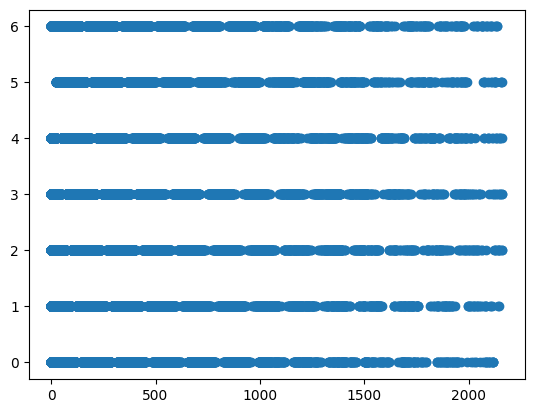

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(train['CI_HOUR'], train['weekday'])
plt.show()


## 모델 학습 및 특성 중요도 확인

Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


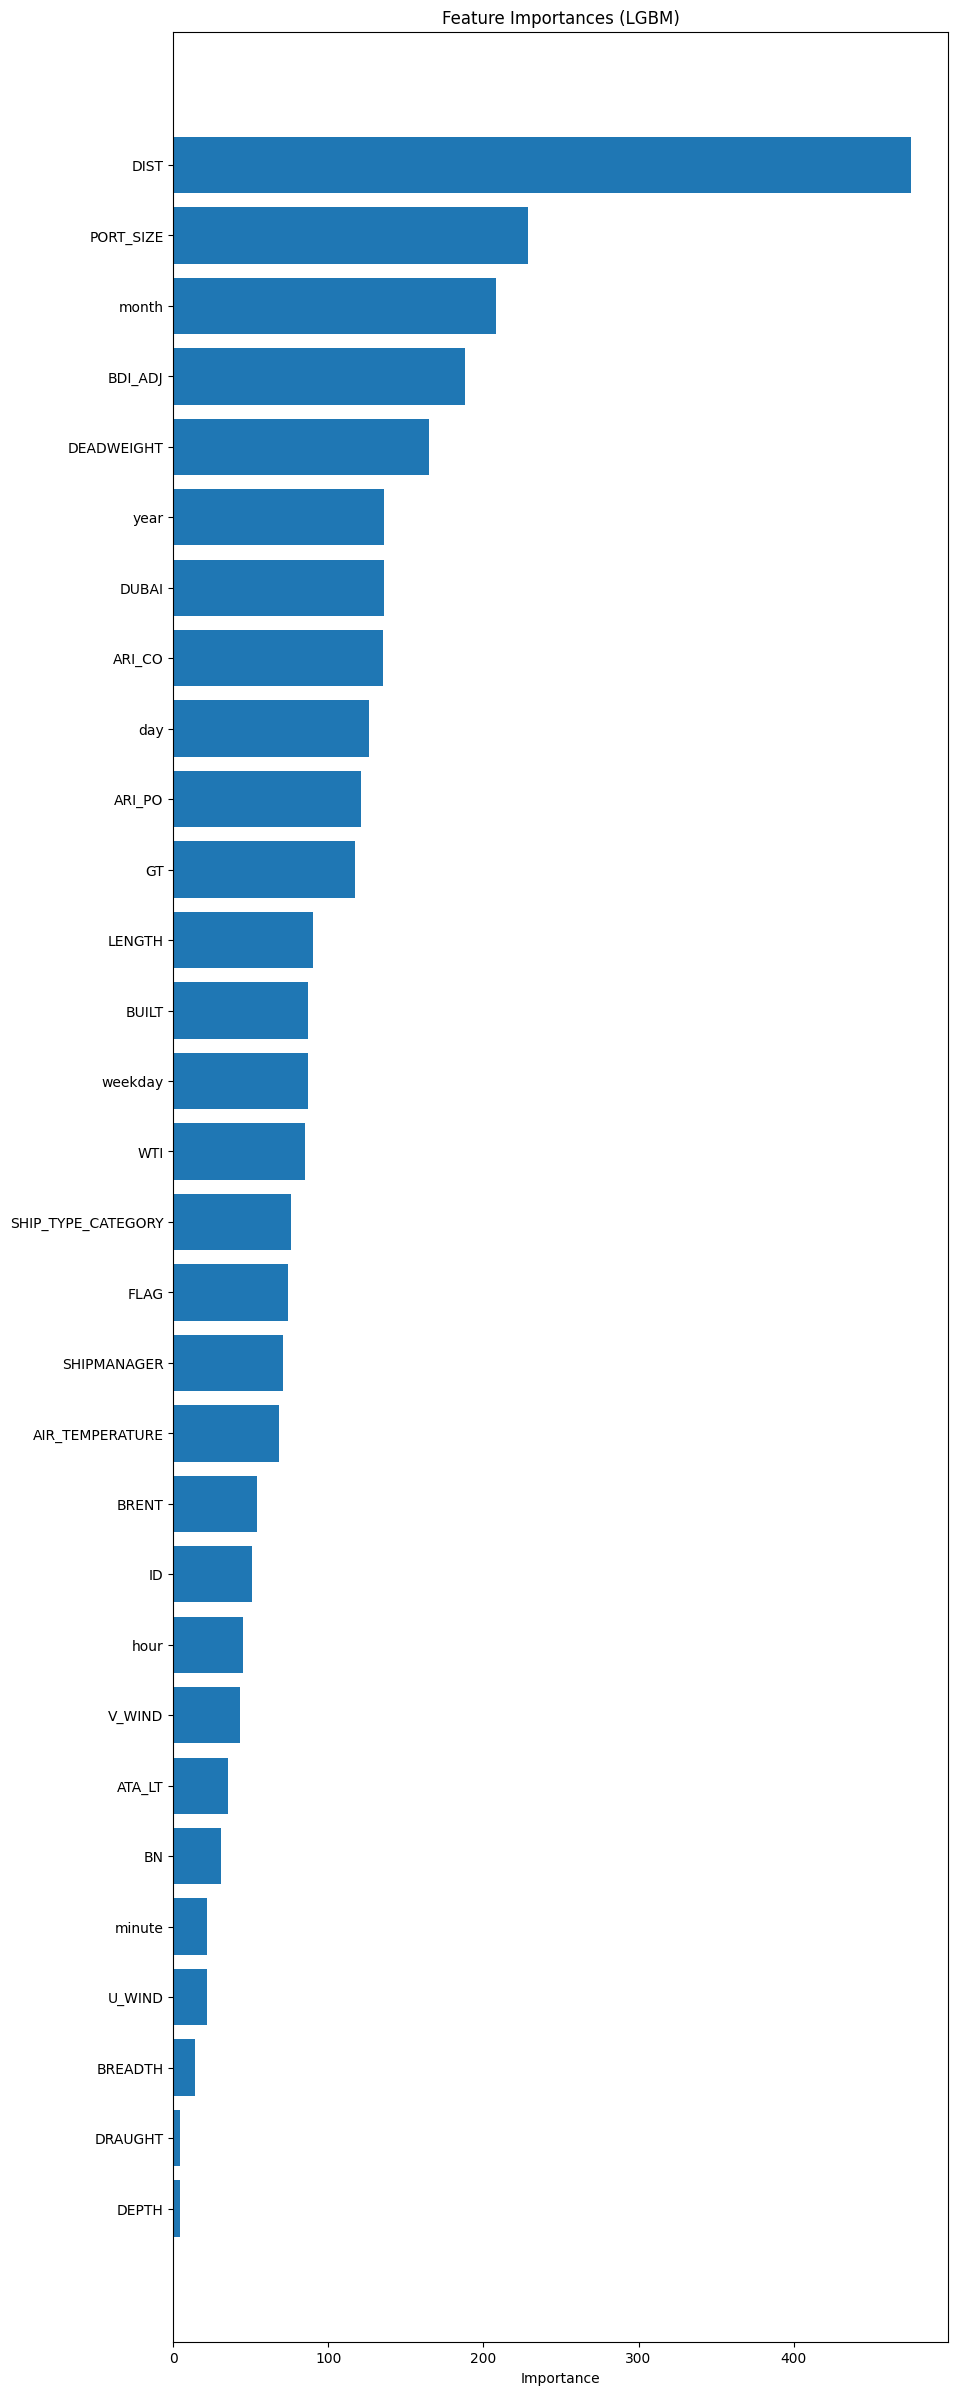

In [ ]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

## 특성 중요도로부터 Feature Selection

In [ ]:
threshold = 85 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

## K-Fold Model Fitting & Validation

In [ ]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]
    
    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)
    
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    
    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 62.047288


Processing folds:  20%|██        | 1/5 [00:01<00:04,  1.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.719969


Processing folds:  40%|████      | 2/5 [00:02<00:03,  1.12s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.754815


Processing folds:  60%|██████    | 3/5 [00:03<00:02,  1.10s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.868218


Processing folds:  80%|████████  | 4/5 [00:04<00:01,  1.09s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.995298


Processing folds: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]

Validation : MAE scores for each fold: [52.64372300947119, 54.21259302652475, 53.81358286835421, 53.27999456243711, 53.30398273099311]
Validation : MAE: 53.45077523955608


## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./baseline_submit.csv', index=False)